# Get and explore dataset

In [1]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import re

In [2]:
# Make results reproducible - set random seed
from numpy.random import seed
seed(42)

In [3]:
negative_file = "negative.txt"
positive_file = "positive.txt"

In [4]:
# Do not modify - helper function to load and preprocess data
def filter_words(line):    
    line = re.sub(r'[^\w\s]','',line.rstrip())
    words = line.split(" ") 
    words = [i.lower() for i in words if i]      
    return " ".join(words)

def load_data(filename):
    thefile = open(filename, 'r') 
    lines = thefile.readlines() 

    data = []
    for l in range(0,len(lines)): 
        if(lines[l-1].strip() == "<title>"): 
            theline = filter_words(lines[l])
            if(len(theline) < 50):
                data.append(theline)            
            
    return data

# Helper function to convert categorical data to class label
def to_word_label(y):
    y = to_class(y)   
    return ["positive" if i==0 else "negative" for i in y]

# Helper function to convert class label to numeric label
def to_numeric_label(y):
    return [0 if i=="positive" else 1 for i in word_labels]

# Helper function: this function needs to be called before sending arrays to sklearn metrics,
# it converts back to class form from categorical form. ie: [1,0] --> 0, [0,1] --> 1
def to_class(y):
    return np.argmax(y,axis=1) 

In [5]:
positive = load_data(positive_file)
negative = load_data(negative_file)

print(positive[0:10])
print(negative[0:10])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book', 'to the point and beautifully illustrated', 'at least somebody has got it', 'beautifully written heartwarming story', 'an excellent cookbook full of delicious recipes', 'an outstanding resource']
['horrible book horrible', 'shallow selfindulgence', 'horrible book horrible', 'disappointment', 'a disappointing mess', 'save your money there are better books out there', 'thank you but no thanks', 'unendurable', 'the hard way', 'some good info among the political commercial']


In [6]:
# Do not modify - Combines the positive and negative reviews into a single list and create labels
data = positive + negative
word_labels = ["positive"] * len(positive) + ["negative"] * len(negative) 

# Converts labels to numbers in one-hot encoding - [1, 0] (positive) or [0, 1] (negative)
from keras.utils import to_categorical
labels  = to_categorical(to_numeric_label(word_labels))

Using TensorFlow backend.


In [7]:
# Write some code to investigate the dataset. 
# - Calculate and report the mean review size, its standard deviation and create a boxplot.
# - Calculate the number of words in the dataset
# - Perform any other dataset investigation that you feel would be valuable
 

In [8]:
# Section: Hypothesis testing
# - What is the mean number of characters in positive and negative reviews respectively?
# - What is the standard deviation around this mean for each?
# - Conduct a hypothesis test to compare these values.
# - Define a null and alternative hypothesis
# - Use Scipy's t statistic and a significance level of 0.05
# - Ensure you indicate using comments the different steps you follow to conduct your hypothesis test


In [9]:
# Do not modify - Tokenize the vocabulary 
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=25)

tokenizer.fit_on_texts(data) #create the vocabularry

tokenized_data = tokenizer.texts_to_sequences(data) #tokenize the data using the vocabulary

vocab_size = len(tokenizer.word_index) + 1 

# Compare a sample of the data before and after tokenization
print(data[0:5])
print(tokenized_data[0:5])

['one of the best crichton novels', 'the medicine of the future', 'beautiful', 'for lovers of robicheaux', 'a good book']
[[18, 4, 2, 19], [2, 4, 2], [], [6, 4], [1, 12, 3]]


# Pre-processing

In [10]:
# Pre-processing
# Write some code to pre-process the data so that each review is the same length
from keras.preprocessing.sequence import pad_sequences
maxlen=25
padded_docs = pad_sequences(tokenized_data, maxlen=maxlen, padding='post')

In [11]:
# Write some code to split the data into a training and test set. Make sure you shuffle the data. Use 20% for the test set.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.20, random_state=42)

In [12]:

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

# Fill in the following function so it
# - makes a prediction for the test set given the model
# - reports the precision, recall and f1 score. Also print the confusion matrix. 
# You will need to use the helper to_class function to convert y_pred and y_test before supplying them to the sklearn functions.

def assess_model(model, x_test, y_test):      
    #To do
    y_pred = model.predict(x_test)
   # y_pred = to_class(y_pred)
    y_pred = to_word_label(y_pred)
    y_test = to_word_label(y_test)
    metric_1 = classification_report(y_test, y_pred)
    metric_2 = confusion_matrix(y_test, y_pred)
    print(metric_1)
    print(metric_2)  

# Build and tune model

Define network architecture

In [13]:
import tensorflow
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from keras.layers.embeddings import Embedding

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Masking, TimeDistributed, Embedding, SpatialDropout1D, BatchNormalization
from tensorflow. keras.utils import plot_model

model = Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=200, input_length=25))
model.add(SpatialDropout1D(0.2))
model.add(BatchNormalization())
model.add(LSTM(units=32))
model.add(Dense(units=2, activation='softmax'))
#model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 200)           512000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 25, 200)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 200)           800       
_________________________________________________________________
lstm (LSTM)                  (None, 32)                29824     
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 542,690
Trainable params: 542,290
Non-trainable params: 400
_________________________________________________________________
None


Train model

In [14]:
# fit the model
history = model.fit(x_train, y_train, batch_size=128, epochs=100, verbose=1, validation_split=0.2)
#model.fit(x_train, y_train, epochs=100, verbose=0)

Epoch 1/100
9/9 [==============================] - 1s 76ms/step - loss: 0.7379 - acc: 0.4865 - val_loss: 0.6917 - val_acc: 0.5331
Epoch 2/100
9/9 [==============================] - 0s 27ms/step - loss: 0.7161 - acc: 0.5092 - val_loss: 0.6943 - val_acc: 0.4669
Epoch 3/100
9/9 [==============================] - 0s 27ms/step - loss: 0.7248 - acc: 0.4830 - val_loss: 0.6940 - val_acc: 0.4669
Epoch 4/100
9/9 [==============================] - 0s 27ms/step - loss: 0.7025 - acc: 0.5013 - val_loss: 0.6930 - val_acc: 0.5331
Epoch 5/100
9/9 [==============================] - 0s 26ms/step - loss: 0.7086 - acc: 0.4900 - val_loss: 0.6932 - val_acc: 0.4669
Epoch 6/100
9/9 [==============================] - 0s 25ms/step - loss: 0.7003 - acc: 0.5187 - val_loss: 0.6926 - val_acc: 0.5331
Epoch 7/100
9/9 [==============================] - 0s 25ms/step - loss: 0.6922 - acc: 0.5266 - val_loss: 0.6928 - val_acc: 0.5331
Epoch 8/100
9/9 [==============================] - 0s 25ms/step - loss: 0.7029 - acc: 0.50

9/9 [==============================] - 0s 26ms/step - loss: 0.6940 - acc: 0.5048 - val_loss: 0.6928 - val_acc: 0.5819
Epoch 64/100
9/9 [==============================] - 0s 25ms/step - loss: 0.6944 - acc: 0.5118 - val_loss: 0.6921 - val_acc: 0.5331
Epoch 65/100
9/9 [==============================] - 0s 26ms/step - loss: 0.6925 - acc: 0.5135 - val_loss: 0.6927 - val_acc: 0.5645
Epoch 66/100
9/9 [==============================] - 0s 25ms/step - loss: 0.6962 - acc: 0.4682 - val_loss: 0.6923 - val_acc: 0.5331
Epoch 67/100
9/9 [==============================] - 0s 26ms/step - loss: 0.6973 - acc: 0.4900 - val_loss: 0.6920 - val_acc: 0.5331
Epoch 68/100
9/9 [==============================] - 0s 25ms/step - loss: 0.6932 - acc: 0.5248 - val_loss: 0.6926 - val_acc: 0.5401
Epoch 69/100
9/9 [==============================] - 0s 26ms/step - loss: 0.6944 - acc: 0.5109 - val_loss: 0.6929 - val_acc: 0.4913
Epoch 70/100
9/9 [==============================] - 0s 25ms/step - loss: 0.6940 - acc: 0.5057 - 

Examine performance of model

In [15]:
score = model.evaluate(x_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

12/12 [==============================] - 0s 2ms/step - loss: 0.6695 - acc: 0.6045
Test Score: 0.6694649457931519
Test Accuracy: 0.6044568419456482


Plot graphs for accuracy and loss

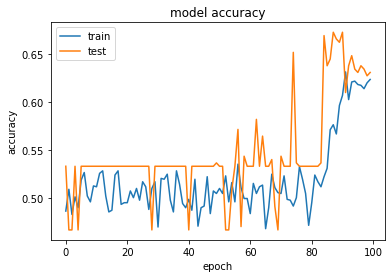

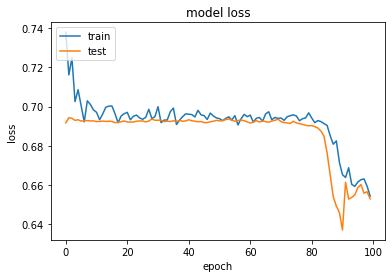

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# Make a prediction

In [17]:
# This is a very small set of completed new data to use to make predictions.
prediction_data = ["this book is fabulous","i hated this book", "the best", "no good", "okay"]
tokenized = tokenizer.texts_to_sequences(prediction_data)
padded = pad_sequences(tokenized, padding='post', maxlen=maxlen)

# Supply this data to each of your models and see how it does. 
# You can call the helper function "to_word_label" to map the output of the model to the name of the
# class it was predicted to belong to.
y_pred = model.predict(padded)
to_class(y_pred)




array([1, 1, 0, 0, 1], dtype=int64)

In [18]:
assess_model(model, x_test, y_test)

              precision    recall  f1-score   support

    negative       0.59      0.75      0.66       183
    positive       0.64      0.45      0.53       176

    accuracy                           0.60       359
   macro avg       0.61      0.60      0.59       359
weighted avg       0.61      0.60      0.59       359

[[138  45]
 [ 97  79]]
